In [37]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
from pypfopt import DiscreteAllocation
from pypfopt.expected_returns import mean_historical_return
import yfinance as yf
from IPython.display import Markdown as md

In [168]:

# Read in price data
years = 20
df = pd.read_csv("PyPortfolioOpt/tests/resources/stock_prices.csv", parse_dates=True, index_col="date")
etf = pd.read_csv("/home/hillenr/drop/investing/PortfolioResearch/VG_etfs.csv")
funds = pd.read_csv("/home/hillenr/drop/investing/PortfolioResearch/VG_funds.csv")
# etf_sector = etf[etf.Type == "Stock - Sector"]
etf_tickers = etf["Symbol"].values.tolist()
fund_tickers = funds["Symbol"].values.tolist()
# etf_tickers = ["SPY", "VBIAX", "VWIAX", "VTSAX", "BND"] + etf_tickers
tickers = ["SPY"] + fund_tickers + etf_tickers
close = yf.download(" ".join(tickers),
  period = str(years) + "y",
  interval = "1d",
  #group_by = 'ticker',
)["Adj Close"]
# print(etf_close)
print(etf)
print(funds)
returns = np.log(close/close.shift())
returns = returns.fillna(0)
# print(returns)

[*********************100%***********************]  155 of 155 completed
                                         Name Symbol  \
0                      Consumer Discretionary    VCR   
1                            Consumer Staples    VDC   
2                       Dividend Appreciation    VIG   
3            Emerging Markets Government Bond   VWOB   
4                                      Energy    VDE   
5                  Extended Duration Treasury    EDV   
6                             Extended Market    VXF   
7                                  Financials    VFH   
8                        FTSE All-World ex-US    VEU   
9              FTSE All-World ex-US Small-Cap    VSS   
10                     FTSE Developed Markets    VEA   
11                      FTSE Emerging Markets    VWO   
12                                FTSE Europe    VGK   
13                               FTSE Pacific    VPL   
14                 Global ex-U.S. Real Estate   VNQI   
15                             

In [205]:
pd.options.display.max_rows = 999

def get_stats(period, output=True, tickers=""):
  wks = str(period * 52) + "W"
  returns_from = returns.last(wks)
  if len(tickers) > 0:
    returns_from = returns_from[tickers]
  data = pd.DataFrame()
  data["mean"] = returns_from.mean()*252
  data["std"] = returns_from.std()*np.sqrt(252)
  data["sharpe"] = (data["mean"] - 0.03) / data["std"]
  for col in returns_from.columns:
    data.loc[col, "beta"],data.loc[col, "alpha"],data.loc[col, "r_val"],_,_ = stats.linregress(returns_from['SPY'].iloc[1:],returns_from[col].iloc[1:])
  data["alpha"] = data["alpha"] * 252
  if output:
    print(f"Last {str(period)} years\n")
    data_sr = data.sort_values(by=['sharpe'], ascending=False)
    print(data_sr)
    print()
    first_5 = data_sr.index.values.tolist()[0:4]
    np.exp(np.cumsum(returns_from[first_5])).plot(figsize=(10,8),title=f"Last {str(period)} years", logy=True)
  return(data)


In [224]:
def sum_stats(output=True, tickers=""):
  dfs = {}
  top_5_col = set()
  for years in [1, 2, 3, 5, 10, 15, 20]:
    dfs[str(years)] = get_stats(years, output, tickers)
    top_5 = set(dfs[str(years)].sort_values(by=["sharpe"], ascending=False).iloc[0:5].index.values)
    top_20 = set(dfs[str(years)].sort_values(by=["sharpe"], ascending=False).iloc[0:20].index.values)
    top_5_col = top_5_col.union(top_5).intersection(top_20)
  dfs_mean = pd.concat(dfs.values(), axis=1, keys=dfs.keys()).groupby(axis=1,level=1).mean()
  if not output: return(list(top_5_col))
  for sort_i in ["sharpe", "mean", "alpha"]:
    print(f"Sorted by {sort_i}\n")
    print(dfs_mean.sort_values(by=[sort_i], ascending=False))
    print()
  return(list(top_5_col))

In [225]:
top_x = sum_stats(False)
top_x
# top_x.remove("VDE")
# top_x.remove("VGENX")
top_x.insert(0, "SPY")
sum_stats(True, top_x)

['VWELX', 'VDC', 'VDIGX', 'VHT', 'VWINX', 'VGHCX', 'VWEHX', 'VGT', 'VOO']

In [209]:
top_x

0.3839170632186506 0.0004047448554899992


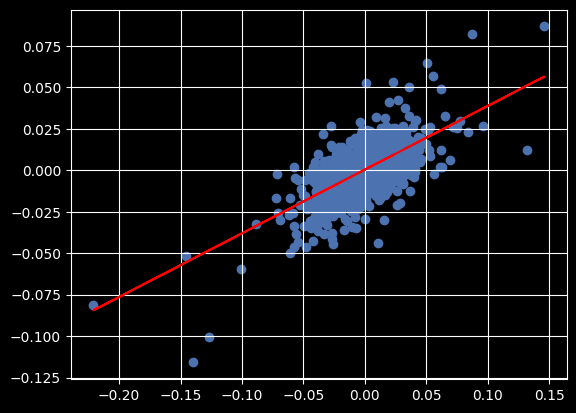

In [120]:
slope, intercept, _, _, _ = stats.linregress(etf_returns['VDE'].last('10Y'),etf_returns['SPY'].last('10Y'))
print(slope, intercept)
plt.scatter(etf_returns['VDE'].last('10Y'),etf_returns['SPY'].last('10Y'))
plt.plot(etf_returns['VDE'].last('10Y'),etf_returns['VDE'].last('10Y') * slope + intercept, color='red')
plt.grid()

In [37]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import objective_functions
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

mu = mean_historical_return(etf_close)
S = CovarianceShrinkage(etf_close).ledoit_wolf()
# print(S)
ef = EfficientFrontier(mu, S)
ef.add_objective(objective_functions.L2_reg, gamma=2.0)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
print(ef.portfolio_performance(verbose=True))

latest_prices = get_latest_prices(etf_close)
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=100000)
allocation, leftover = da.lp_portfolio()
print(allocation)

/home/hillenr/dev/invest/invest/lib/python3.10/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:257: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('VAW', 0.0), ('VCR', 0.0), ('VDC', 0.03542), ('VDE', 0.93605), ('VFH', 0.0), ('VGT', 0.0), ('VHT', 0.0), ('VIS', 0.0), ('VNQ', 0.0), ('VOX', 0.0), ('VPU', 0.02852)])
Expected annual return: 69.7%
Annual volatility: 33.8%
Sharpe Ratio: 2.00
(0.6972451557529381, 0.338086219670399, 2.00317290782566)
{'VDC': 18, 'VDE': 730, 'VPU': 19}


/home/hillenr/dev/invest/invest/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
